In [1]:
!pip install qiskit qiskit-aer

In [2]:
# Quantum Phase Estimation (QPE) using Qiskit 2.x

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

def qpe_circuit(num_count_qubits, unitary, theta):
    """
    Constructs the Quantum Phase Estimation (QPE) circuit.
    num_count_qubits: number of counting qubits
    unitary: unitary gate (to apply controlled operations)
    theta: phase parameter (for U gate)
    """
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)

    # Step 1: Apply Hadamard gates on counting qubits
    qc.h(range(num_count_qubits))

    # Step 2: Prepare eigenstate (|1>) for the target qubit
    qc.x(num_count_qubits)

    # Step 3: Apply controlled unitary operations
    for qubit in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)

    # Step 4: Apply inverse QFT to counting qubits
    inverse_qft(qc, num_count_qubits)

    # Step 5: Measure counting qubits
    qc.measure(range(num_count_qubits), range(num_count_qubits))

    return qc

In [3]:
def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc

In [4]:
def run_qpe(num_count_qubits=3, theta=0.125):
    """Executes the QPE circuit and visualizes the phase estimation result."""
    simulator = AerSimulator()
    qc = qpe_circuit(num_count_qubits, "U", theta)
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048).result()
    counts = result.get_counts()
    plot_histogram(counts)
    plt.show()
    print(qc.draw(output='text'))

In [5]:
if __name__ == "__main__":
    num_count_qubits = 3
    theta = 0.125  # phase value (1/8)
    print(f"Running Quantum Phase Estimation with {num_count_qubits} counting qubits and phase {theta}")
    run_qpe(num_count_qubits, theta)

Running Quantum Phase Estimation with 3 counting qubits and phase 0.125
     ┌───┐                            ┌───┐                                   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                            »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌─┐           
«q_0: ┤M├───────────
«     

In [6]:
!pip install qiskit qiskit-aer


In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt


In [8]:
def inverse_qft(qc, n):
    """Apply the inverse Quantum Fourier Transform on n qubits."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc


In [9]:
def qpe_circuit(num_count_qubits, theta):
    """
    Constructs the Quantum Phase Estimation (QPE) circuit.
    num_count_qubits: number of counting qubits
    theta: phase parameter (for U gate)
    """
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)

    # Step 1: Apply Hadamard gates
    qc.h(range(num_count_qubits))

    # Step 2: Prepare eigenstate |1>
    qc.x(num_count_qubits)

    # Step 3: Apply controlled-U operations
    for qubit in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)

    # Step 4: Apply inverse QFT
    inverse_qft(qc, num_count_qubits)

    # Step 5: Measure counting qubits
    qc.measure(range(num_count_qubits), range(num_count_qubits))

    return qc


In [10]:
def theoretical_binary(theta, num_count_qubits):
    """Compute the expected binary result for given theta."""
    value = int(theta * (2 ** num_count_qubits))
    binary = format(value, f'0{num_count_qubits}b')
    return binary


In [11]:
def run_qpe(num_count_qubits=3, theta=0.125, noisy=False, visualize=False):
    """Run QPE circuit, visualize results, and compare with theory."""
    if noisy:
        noise_model = NoiseModel()
        error = depolarizing_error(0.01, 1)
        noise_model.add_all_qubit_quantum_error(error, ['u3', 'cx'])
        simulator = AerSimulator(noise_model=noise_model)
        print("Running with noise model...")
    else:
        simulator = AerSimulator()

    qc = qpe_circuit(num_count_qubits, theta)

    # ✅ Optional: visualize inverse QFT structure before measurement
    if visualize:
        display(qc.draw('mpl'))

    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=2048).result()
    counts = result.get_counts()

    expected = theoretical_binary(theta, num_count_qubits)
    print(f"\nTheoretical phase (θ={theta}): binary = {expected} -> decimal = {int(expected, 2)/(2**num_count_qubits):.3f}")

    plot_histogram(counts)
    plt.title(f"QPE Output (θ={theta}, {num_count_qubits} qubits)")
    #plt.show()

    print(qc.draw(output='text'))



=== Task 1: QPE with θ = 0.125 and 3 counting qubits ===

Theoretical phase (θ=0.125): binary = 001 -> decimal = 0.125
     ┌───┐                            ┌───┐                                   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                            »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »


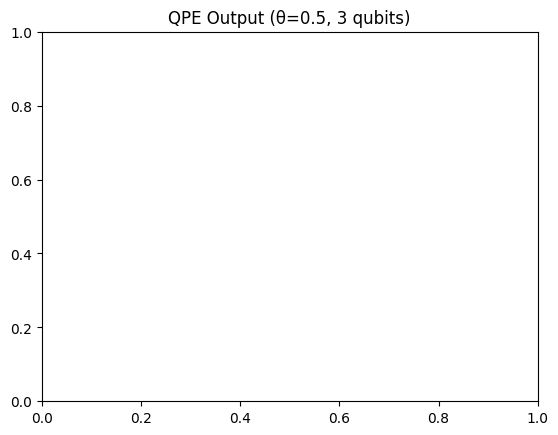

In [12]:
#Task 1
theta_values = [0.125, 0.25, 0.375, 0.5]

for theta in theta_values:
    print(f"\n=== Task 1: QPE with θ = {theta} and 3 counting qubits ===")
    run_qpe(num_count_qubits=3, theta=theta)



=== Task 2: QPE with higher precision (4 counting qubits) ===

Theoretical phase (θ=0.125): binary = 0010 -> decimal = 0.125
     ┌───┐                                    ┌───┐                         »
q_0: ┤ H ├─■────────────────────────────────X─┤ H ├─■──────────────■────────»
     ├───┤ │                                │ └───┘ │P(-π/2) ┌───┐ │        »
q_1: ┤ H ├─┼────────■─────────────────X─────┼───────■────────┤ H ├─┼────────»
     ├───┤ │        │                 │     │                └───┘ │P(-π/4) »
q_2: ┤ H ├─┼────────┼────────■────────X─────┼──────────────────────■────────»
     ├───┤ │        │        │              │                               »
q_3: ┤ H ├─┼────────┼────────┼──────■───────X───────────────────────────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)  │P(2π)                                  »
q_4: ┤ X ├─■────────■────────■──────■───────────────────────────────────────»
     └───┘                                                                  »
c: 4/═══════════

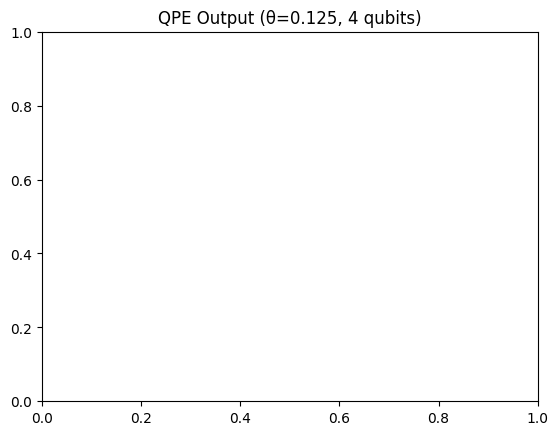

In [13]:
#Task 2
print("\n=== Task 2: QPE with higher precision (4 counting qubits) ===")
run_qpe(num_count_qubits=4, theta=0.125)



=== Task 3: Theoretical vs Simulation Output ===

Theoretical phase (θ=0.375): binary = 011 -> decimal = 0.375
     ┌───┐                               ┌───┐                         »
q_0: ┤ H ├─■───────────────────────────X─┤ H ├─■──────────────■────────»
     ├───┤ │                           │ └───┘ │P(-π/2) ┌───┐ │        »
q_1: ┤ H ├─┼─────────■─────────────────┼───────■────────┤ H ├─┼────────»
     ├───┤ │         │                 │                └───┘ │P(-π/4) »
q_2: ┤ H ├─┼─────────┼─────────■───────X──────────────────────■────────»
     ├───┤ │P(3π/4)  │P(3π/2)  │P(3π)                                  »
q_3: ┤ X ├─■─────────■─────────■───────────────────────────────────────»
     └───┘                                                             »
c: 3/══════════════════════════════════════════════════════════════════»
                                                                       »
«               ┌─┐           
«q_0: ──────────┤M├───────────
«               └╥┘    

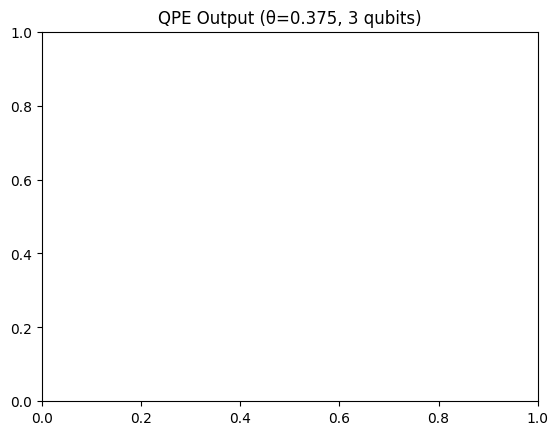

In [14]:
#Task 3
print("\n=== Task 3: Theoretical vs Simulation Output ===")
run_qpe(num_count_qubits=3, theta=0.375)


In [15]:
!pip install pylatexenc


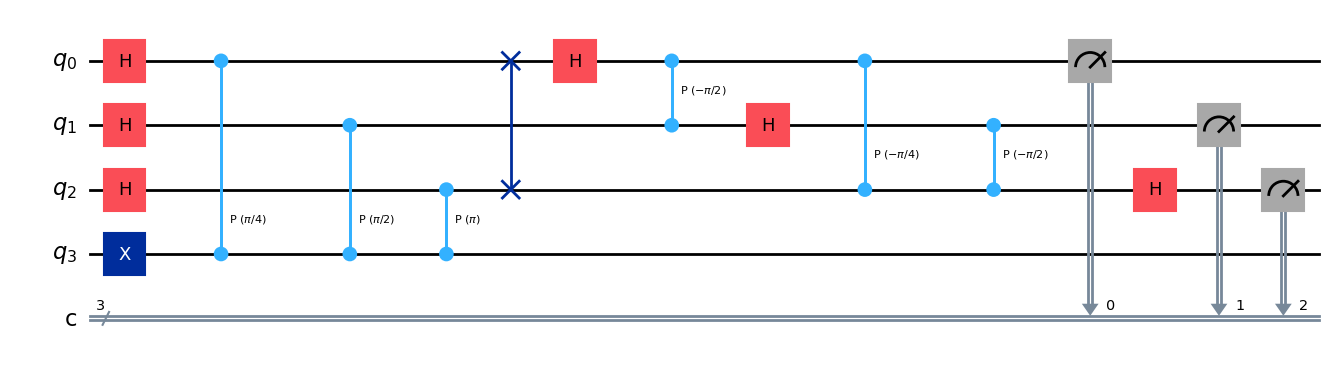


Theoretical phase (θ=0.125): binary = 001 -> decimal = 0.125
     ┌───┐                            ┌───┐                                   »
q_0: ┤ H ├─■────────────────────────X─┤ H ├─■──────────────■──────────────────»
     ├───┤ │                        │ └───┘ │P(-π/2) ┌───┐ │                  »
q_1: ┤ H ├─┼────────■───────────────┼───────■────────┤ H ├─┼─────────■────────»
     ├───┤ │        │               │                └───┘ │P(-π/4)  │P(-π/2) »
q_2: ┤ H ├─┼────────┼────────■──────X──────────────────────■─────────■────────»
     ├───┤ │P(π/4)  │P(π/2)  │P(π)                                            »
q_3: ┤ X ├─■────────■────────■────────────────────────────────────────────────»
     └───┘                                                                    »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌─┐           
«q_0: ┤M├───────────
«     └╥┘     ┌─

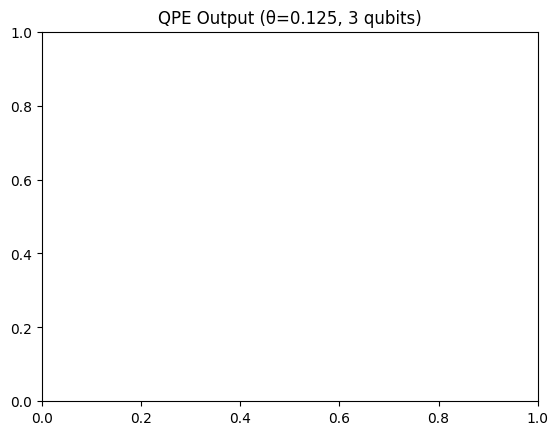

In [16]:
run_qpe(num_count_qubits=3, theta=0.125, visualize=True)


In [18]:
#Task 5
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()

# Define 1-qubit and 2-qubit depolarizing errors
error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

# Apply correctly
noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])


Text(0.5, 1.0, 'QPE with Noise Model')

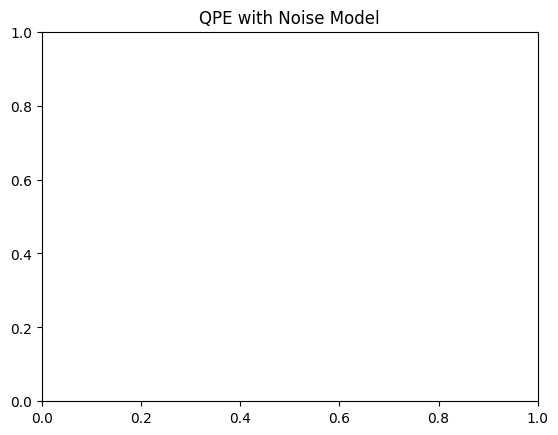

In [21]:
# ✅ Task 5: Noise Simulation with Depolarizing Error

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt

# Function: inverse QFT
def inverse_qft(qc, n):
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / 2 ** (j - k), k, j)
        qc.h(j)
    return qc

# Function: QPE circuit
def qpe_circuit(num_count_qubits, theta):
    qc = QuantumCircuit(num_count_qubits + 1, num_count_qubits)
    qc.h(range(num_count_qubits))
    qc.x(num_count_qubits)
    for qubit in range(num_count_qubits):
        qc.cp(2 * np.pi * theta * (2 ** qubit), qubit, num_count_qubits)
    inverse_qft(qc, num_count_qubits)
    qc.measure(range(num_count_qubits), range(num_count_qubits))
    return qc

# ✅ Define Noise Model
noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# ✅ Initialize simulator
simulator = AerSimulator()

# ✅ Build, transpile, and run circuit
qc = qpe_circuit(num_count_qubits=3, theta=0.125)
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=2048, noise_model=noise_model).result()

# ✅ Plot results
counts = result.get_counts()
plot_histogram(counts)
plt.title("QPE with Noise Model")
#plt.show()
